# Pr10-2: 3DCGのライティングモデル

Lambert反射はどの方向から見ても反射の仕方が一定で，つやの無い質感の反射になります．

出力される明るさ$I_d$は，入射光方向$\mathbf{L}$（ライトベクトル）と面の向き$\mathbf{N}$（法線ベクトル）の成す角によって決まります．

$I_d = k_d I_i \mathbf{L} \cdot \mathbf{N}$

- $k_d$: 拡散反射率
- $I_i$: 入射光の強さ
- $\mathbf{L} \cdot \mathbf{N}$: 入射光方向$\mathbf{L}$と面の向き$\mathbf{N}$の成す角

### 各面の法線ベクトルの取り出し

N_fに各面の法線ベクトルを保存した行列データが入っていて，
以下の方法で各面の法線ベクトルNを取り出すことができます．

ループの中身を調整すると，面毎にLambertモデルの計算ができます．

```
# 面法線の取り出し
[N for N in N_f]

# 面毎のLambertモデルの計算
I_d = [lambert_shading(kd, I_i, L, N) for N in N_f]
```

### Work: Lambertモデルを計算してみましょう．

今のlambert_shading関数は，$k_d I_i$だけを計算していて，
$\mathbf{L} \cdot \mathbf{N}$が計算されていません．

ベクトルの内積 $\mathbf{X} \cdot \mathbf{Y}$は，np.dot(X, Y)のように計算できるので，それを利用して関数を修正してください．


In [18]:
# Work: 以下の関数を修正．
def lambert_shading(k_d, I_i, L, N):
    return k_d * I_i *np.dot(L,N)

lambert_shading関数が実装できているとLambert反射の結果が表示されます．

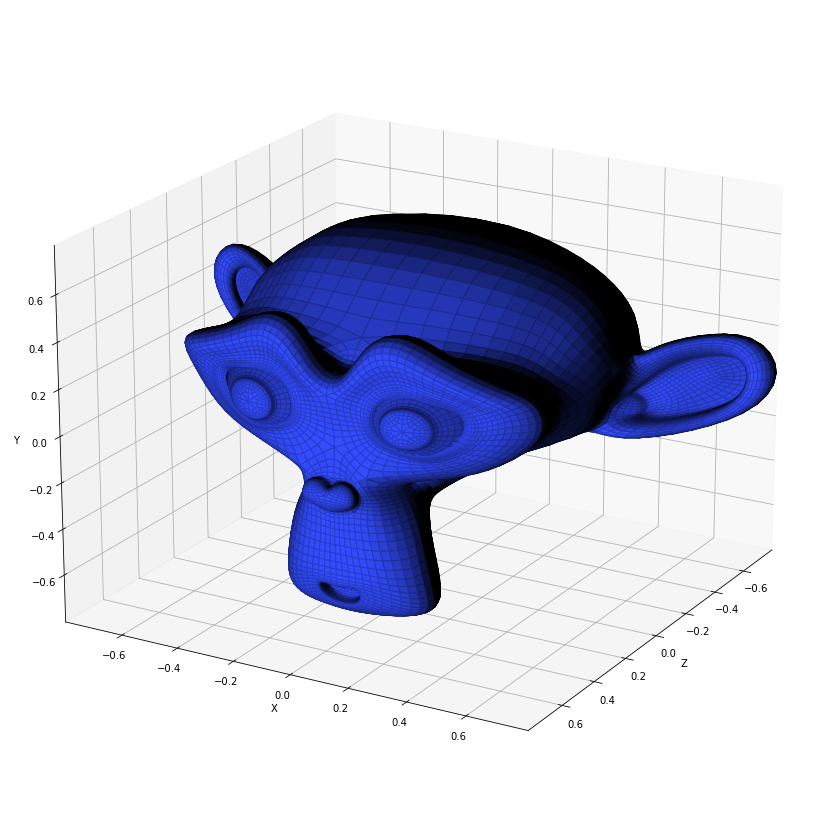

In [19]:
import numpy as np
from mesh import *
from transform import *

mesh =  loadOBJ('suzanne_smooth.obj')
mesh.computeFaceNormals()

P = mesh.V
F = mesh.F
N_f = mesh.N_f

# ライトベクトル
L = np.array([0, 0, 1])

# 入射光の強さ
I_i = 1.0

# 拡散反射率
k_d = np.array([0.2, 0.3, 1.0])

I_d = [lambert_shading(k_d, I_i, L, N) for N in N_f]
I_d = np.clip(I_d, 0, 1)

fig = plt.figure(figsize=(15,15))

viewer = MeshViewer(fig)

viewer.addMesh(P, F, I_d,  edgecolor=0.8*I_d, alpha=1.0, linewidth=1.0)

viewer.setView(elev=20, azim=30)
viewer.show()

Blinnのモデルでは，ライトベクトル$\mathbf{L}$，法線ベクトル$\mathbf{N}$に加えて，視線ベクトル$\mathbf{V}$とハーフベクトル$\mathbf{H}$が登場します．

$\mathbf{H} = \frac{\mathbf{L}+\mathbf{V}}{|| \mathbf{L}+ \mathbf{V} ||}$

$\mathbf{H}$は，光源から出た光を最も上手くカメラ方向に反射できる面の向きを表していて，これと面の向き$\mathbf{N}$の成す角を見ることでハイライト成分を計算できます．

鏡面反射輝度$I_s$は，$\mathbf{L}$を$\mathbf{H}$に置き換えるような形で以下のように計算されます．

$I_s = k_s I_i (\mathbf{H} \cdot \mathbf{N})^{\alpha}$

- $k_s$: 鏡面反射率
- $I_i$: 入射光の強さ
- $\mathbf{H} \cdot \mathbf{N}$: ハーフベクトル$\mathbf{H}$と法線ベクトル$\mathbf{N}$の成す角
- $\alpha$: ハイライトの鋭さ

### Work: Blinnのモデルを計算してみましょう．

今のblinn_shading関数は，$k_s I_i$だけを計算していて，
$(\mathbf{H} \cdot \mathbf{N})^{\alpha}$が計算されていません．

- ベクトルの内積 $\mathbf{X} \cdot \mathbf{Y}$は，```np.dot(X, Y)```のように計算できます．
- $x^{\alpha}$は```x**alpha```のように計算できます．

In [20]:
# Work: 以下の関数を修正．
def blinn_shading(k_s, I_i, H, N, alpha):
  return k_s * I_i * (np.dot(H,N)**alpha)

blinn_shading関数が実装できていると，ハイライトが表示されます．

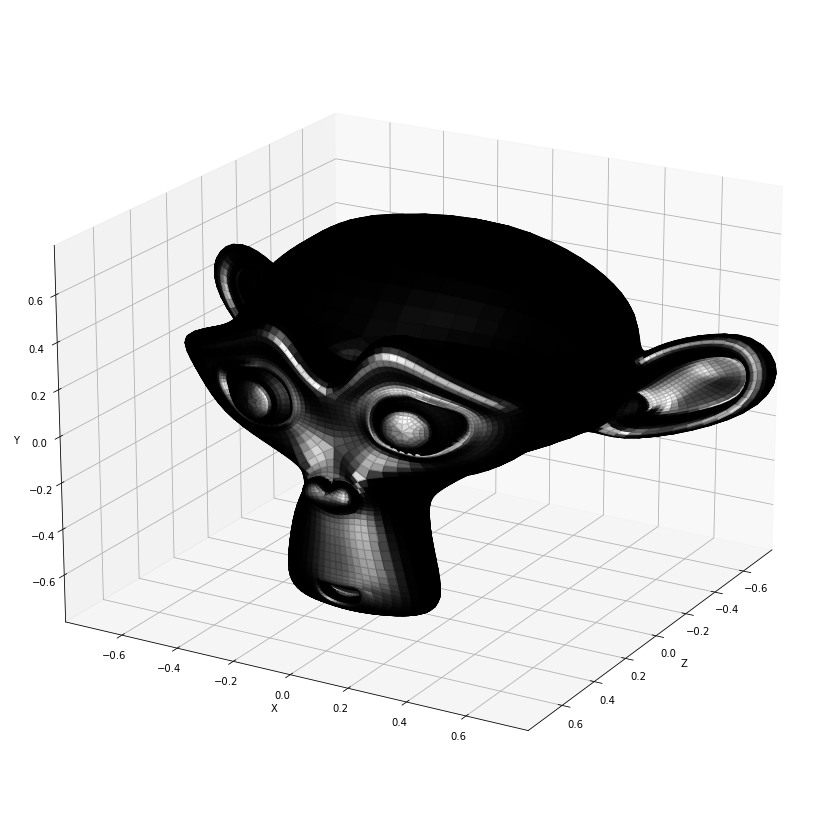

In [21]:
# 入射光の強さ
I_i = 1.0

# 鏡面反射率
k_s = np.array([1.0, 1.0, 1.0])

# ハイライトの鋭さ
alpha = 20

# 視点パラメータ
elev = 20
azim = 30

# ライトベクトル
L = np.array([0, 0, 1])

# 視線ベクトルの計算
R = rotate_y(azim) @ rotate_x(-elev)
V = np.array([0, 0, 1]) @ R[:3,:3].T

# ハーフベクトルの計算
H = L + V
H /= np.linalg.norm(H)

I_s = [blinn_shading(k_s, I_i, H, N, alpha) for N in N_f]
I_s = np.clip(I_s, 0, 1)

fig = plt.figure(figsize=(15,15))

viewer = MeshViewer(fig)

viewer.addMesh(P, F, I_s,  edgecolor=0.8*I_s, alpha=1.0, linewidth=1.0)

viewer.setView(elev=elev, azim=azim)
viewer.show()

## LambertモデルとBlinnモデルの組み合わせ

$I = I_d + I_s$ <br>
　$=  k_d I_i \mathbf{L} \cdot \mathbf{N}+ k_s I_i (\mathbf{H} \cdot \mathbf{N})^{\alpha}$

のように計算して，拡散反射と鏡面反射を組み合わせることができます．

上でlambert_shading，blinn_shading関数が実装されていれば組み合わせた結果が見れます．

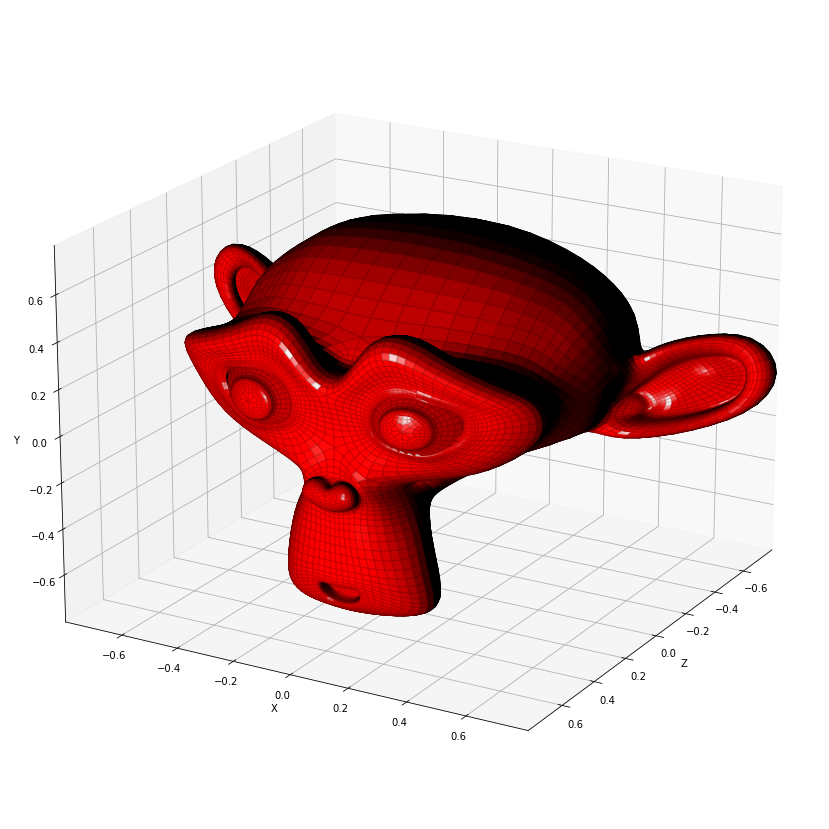

In [23]:
#@title Shadingパラメータ { run: "auto" }

#@markdown 入射光の強さ
I_i = 1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}

#@markdown 拡散反射率 k_d (RGB)
k_d_r = 1.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_d_g = 0.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_d_b = 0.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_d = np.array([k_d_r, k_d_g, k_d_b])

#@markdown 鏡面反射率 k_s (RGB)
k_s_r = 1.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_s_g = 1.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_s_b = 1.0 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
k_s = np.array([1.0, 1.0, 1.0])

#@markdown ハイライトの鋭さ
alpha = 200 #@param {type: "slider", min: 0, max: 200}

#@markdown 視点パラメータ
elev = 20   #@param {type: "slider", min: 0, max: 90}
azim = 30   #@param {type: "slider", min: 0, max: 360}

# ライトベクトル
L = np.array([0, 0, 1])

# 視線ベクトルの計算
R = rotate_y(azim) @ rotate_x(-elev)
V = np.array([0, 0, 1]) @ R[:3,:3].T

# ハーフベクトルの計算
H = L + V
H /= np.linalg.norm(H)


# 拡散反射の計算
I_d = [lambert_shading(k_d, I_i, L, N) for N in N_f]
I_d = np.clip(I_d, 0, 1)

# 鏡面反射の計算
I_s = [blinn_shading(k_s, I_i, H, N, alpha) for N in N_f]
I_s = np.clip(I_s, 0, 1)

# 計算結果の組み合わせ
I = I_d + I_s
I = np.clip(I, 0, 1)

fig = plt.figure(figsize=(15,15))

viewer = MeshViewer(fig)

viewer.addMesh(P, F, I,  edgecolor=0.8*I, alpha=1.0, linewidth=1.0)

viewer.setView(elev=elev, azim=azim)
viewer.show()